In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import sys
sys.path.append('/workspace/utils')
from utils3d_model import *
from optimization_utils import *
from visualize_utils import *


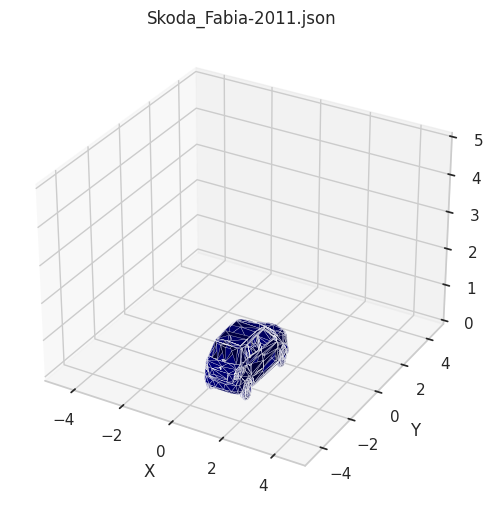

In [2]:
# Set seed for reproducibility
np.random.seed(1)

# Main execution block
folder_path = '/workspace/datasets/apollo/car_models_json'
files = os.listdir(folder_path)

# Load point clouds from specified files
meshes, titles = load_meshes(folder_path, files,len(files))
initial_mesh = meshes["SUV"][1]  # Assuming first point cloud as the initial




#display initial mesh
display_meshes([initial_mesh],[titles["SUV"][1]])


In [3]:
synth_mesh_fn_list = os.listdir("/tmp/gradio")
synth_mesh_fn_list

['58ef51be5aa98b124111fad38f436d1fc593cf33',
 'cc97efcb24a54a6c32b1edea78fb0fe4bf88e8be',
 '73db8bc9004bf24ea8ebae8070579940cca0de7b',
 '5d60519ee47983357660e6575679e5955625c2ab',
 'fdad2bc9e7122f3180dfacd08fca64a0aff9ce48',
 '72aca823e4ea29f11701d79d355b8d7e1ae145ef',
 '1b9fb0ed387b894bd4ceae055865ef4fca49f0cd',
 '1567f2cc2a4ef31ea33d6bd129fdbb1ef20d90ad',
 '6ad3a463785944bcce7d2454dda4e93e156530d5',
 '54854106cdeaa408bf03f09615c0205ded69699e',
 'cb11e40c77ffda42e90d67848f4acc6bf6b8d836',
 '7dd1dc3ee51a0e10416c9befa20bc390b2c14cb6',
 'f90fb8f2aab1e92e02ea91fc348bec05d66941b9',
 'dc2742a97f63f8e01164eaacc671559c4c505ce8',
 '20823f88fbfb8838da0425565e77ae25f752a4e7',
 '1affdd5916d643f6ce0353c6648243229820dfc4',
 'c59825d209651e3307428841bf666a31d5faf1ee',
 '60fa8999c30cab0c1f55cbcc33d548235d258a90',
 '87d18e517826afd609e0f54c51c8656b5de25cf9']

In [4]:
from tqdm import tqdm
def mesh_volume_ply(mesh):
    # Approximates volume using the signed volumes of tetrahedra formed by the mesh faces and the origin
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    volume = 0
    for triangle in tqdm(triangles, desc='Checking triangles'):
        v0, v1, v2 = vertices[triangle]
        tetra_volume = np.abs(np.dot(v0, np.cross(v1, v2))) / 6.0
        volume += tetra_volume
    return volume
import open3d as o3d
synth_methes = []
volumes = []
for mesh_path in tqdm(synth_mesh_fn_list, desc='Loading meshes and calculating volumes'):
    # Load the generated mesh
    dir_path = f"/tmp/gradio/{mesh_path}/"
    file_path = dir_path + os.listdir(dir_path)[0]
    mesh = o3d.io.read_triangle_mesh(file_path)
    synth_methes.append(mesh)
    # Calculate and store the volume
    volumes.append(mesh_volume_ply(mesh))


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading meshes and calculating volumes: 100%|██████████| 19/19 [00:42<00:00,  2.26s/it]


Checking triangles: 100%|██████████| 5000/5000 [00:00<00:00, 24346.00it/s]


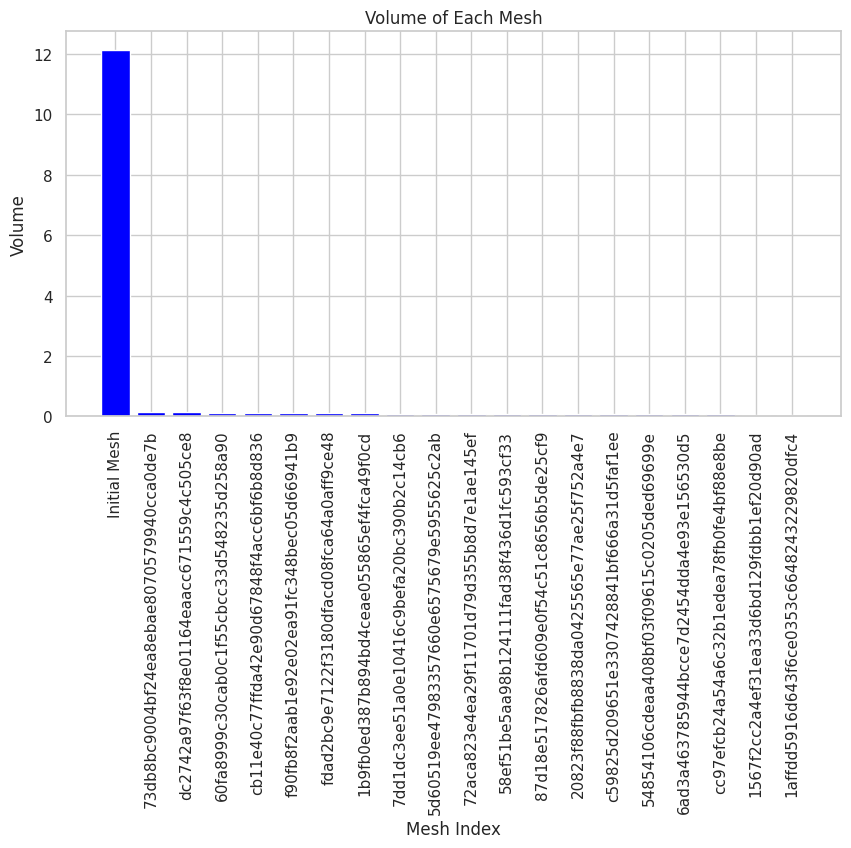

In [5]:
def mesh_volume_json(mesh):
    # Approximates volume using the signed volumes of tetrahedra formed by the mesh faces and the origin
    vertices = mesh[0]
    triangles = mesh[1]
    volume = 0
    for triangle in tqdm(triangles, desc='Checking triangles'):
        v0, v1, v2 = vertices[triangle]
        tetra_volume = np.abs(np.dot(v0, np.cross(v1, v2))) / 6.0
        volume += tetra_volume
    return volume
# Plotting the volumes
real_volume = mesh_volume_json(initial_mesh)
# Sort the volumes and mesh filenames in descending order of volumes
volumes, synth_mesh_fn_list = zip(*sorted(zip(volumes, synth_mesh_fn_list), reverse=True))

#push the initial mesh volume and title to the front of the lists
volumes = (real_volume,) + volumes
synth_mesh_fn_list = ('Initial Mesh',) + synth_mesh_fn_list

plt.figure(figsize=(10, 5))
plt.bar(range(len(volumes)), volumes, color='blue')
plt.xticks(range(len(volumes)), synth_mesh_fn_list, rotation=90)
plt.xlabel('Mesh Index')
plt.ylabel('Volume')
plt.title('Volume of Each Mesh')
plt.show()

In [6]:
volume_scalars = [(real_volume / vol) ** (1/3) for vol in volumes[1:]]
volume_scalars

scaled_meshes = []
for mesh, scale_factor in zip(synth_methes, volume_scalars[1:]):
    # Scale the mesh by the volume scalar
    scaled_vertices = np.asarray(mesh.vertices) * scale_factor
    mesh.vertices = o3d.utility.Vector3dVector(scaled_vertices)
    
    # Optionally: save the scaled mesh or add to a list for further processing
    scaled_meshes.append(mesh)

In [7]:
print(len(scaled_meshes)) 
print(len(volume_scalars))
print(volume_scalars)

18
19
[4.337627058652776, 4.376611617945441, 4.801422259885062, 4.81095767827808, 4.9556170299227, 4.961267427281448, 4.983964523795775, 5.046973047383523, 5.048145272323746, 5.090756813528936, 5.128866217052805, 5.2210365948712605, 5.291941743868811, 5.360117457145135, 5.371877077028752, 5.436479855455542, 5.689314808401996, 5.86722404423096, 5.921191110547557]


In [8]:
np.array(scaled_meshes[0].vertices)

array([[-1.82712078, -0.60890674,  0.33580902],
       [-1.82659788, -0.60788512,  0.33974471],
       [-1.82420156, -0.6120357 ,  0.33646937],
       ...,
       [ 1.69493888,  0.36063946, -0.39409847],
       [ 1.68283233,  0.39311308, -0.39951145],
       [ 1.66125724,  0.42011999, -0.40492446]])

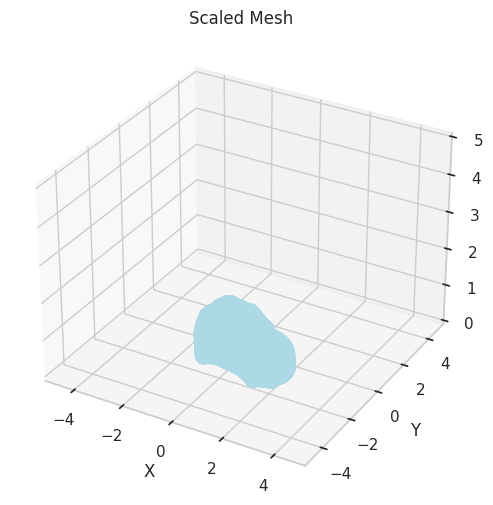

In [15]:
np.array(scaled_meshes[0].vertices).shape
display_point_clouds([np.array(scaled_meshes[0].vertices)], ['Scaled Mesh'])

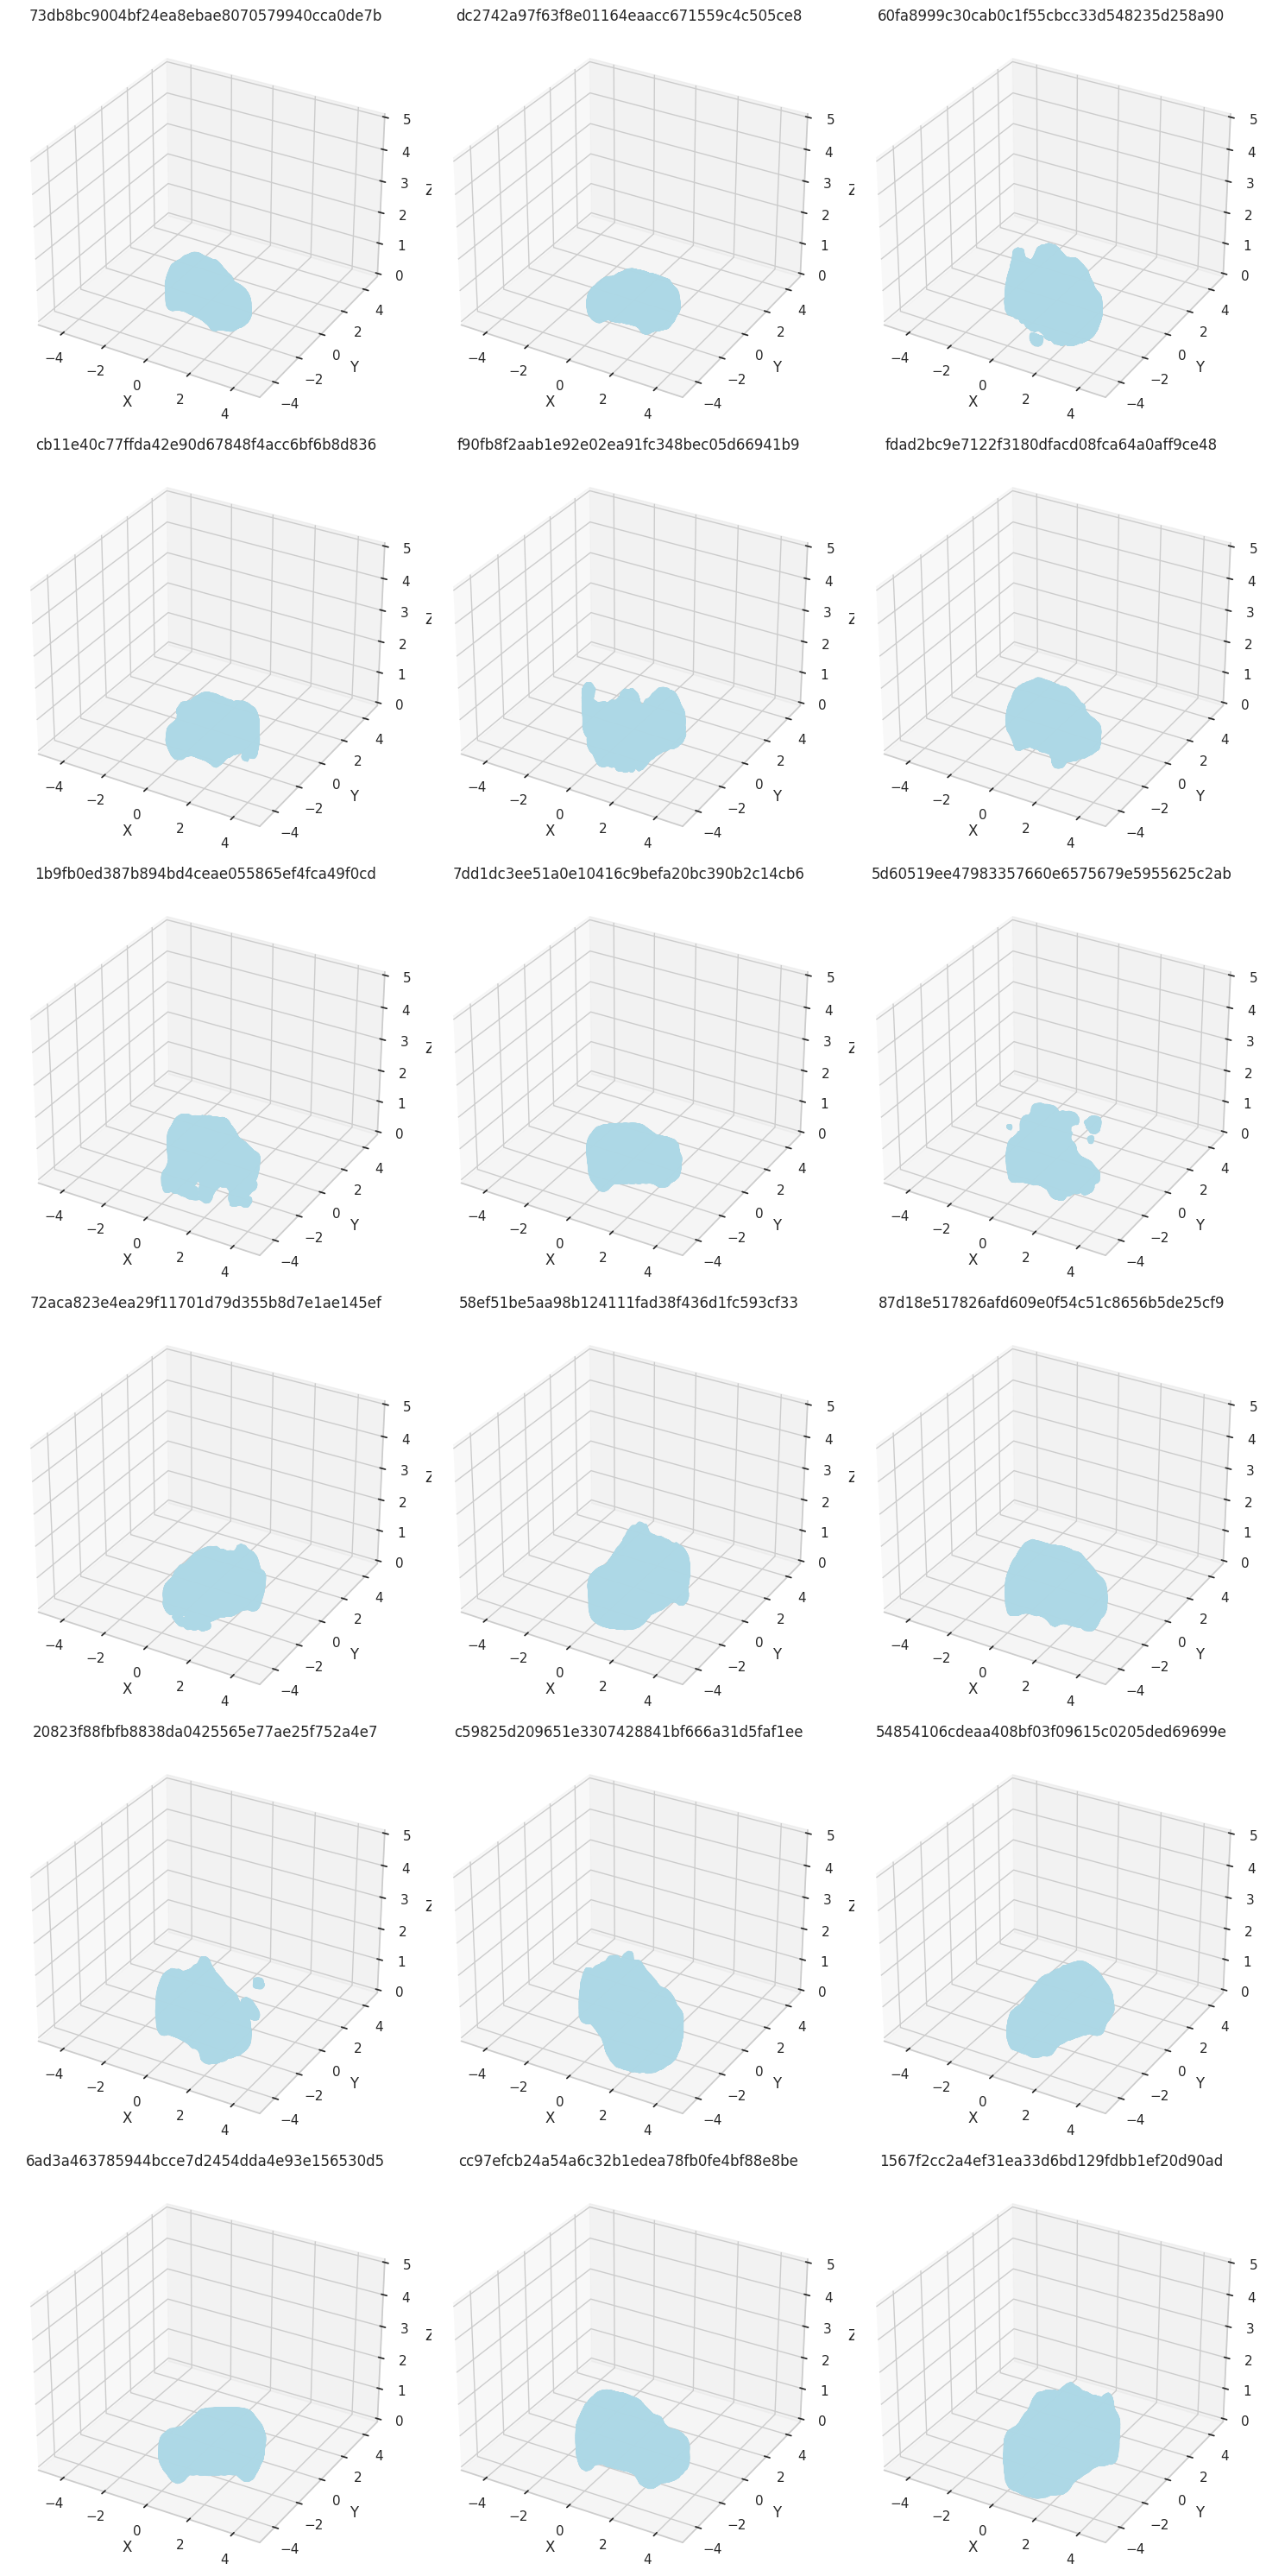

In [17]:
#convert the scaled meshes to numpy arrays
scaled_meshes_np = [np.array(mesh.vertices) for mesh in scaled_meshes]
display_point_clouds(scaled_meshes_np, synth_mesh_fn_list[1:])

In [18]:
actual_tranformation = np.concatenate([[0,0,260* (np.pi / 180)], [0,0,0]])

# Perform multiple optimizations
num_runs = 10
num_trials = 10
df = multiple_optimizations(scaled_meshes_np[0], initial_mesh[0],actual_tranformation, num_runs, num_trials)

KeyboardInterrupt: 